<img src="../../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# Deterministic Creation of Multi-Qubit W State Systems

## _*Benchmarking Competing Algorithms by Quantum Tomography*_ 


***
### Contributors
Pierre Decoodt


### Introduction

A generalized $n$-qubit W state system can be written as$^{[1]}$:
$$ |W_{n}\rangle \; = \; \sqrt{\frac{1}{n}} \: (\:|10...0\rangle \: +  |01...0\rangle \: +...+ |00...1\rangle \:) $$

A specific compact algorithm allows the deterministic creation of W states of any size $n$., as described here:

https://nbviewer.jupyter.org/github/Qiskit/qiskit-tutorial/blob/master/community/teach_me_qiskit_2018/w_state/W%20State%201%20-%20Multi-Qubit%20Systems.ipynb

This algorithm is inspired by Diker's theoretical proposition$^{[2]}$, but is characterized by a linear rather than quadratic progression of the number of gates needed when  $ n $ increases.

In many cases, the QISKit compiler is so smart that it allows safely the programming of circuits without taking into account the architecture of the different final real target devices. This is the approach that is presented here with realization of a compact multi-qubit W state generation program.

For the creation of such states, an other approach is to use a general algorithm of arbitrary initialization, as described _at the end_ of the following tutorial:

https://nbviewer.jupyter.org/github/Qiskit/qiskit-tutorial/blob/master/qiskit/terra/summary_of_quantum_operations.ipynb

Therefore, why worry about using a specific algorithm, sophisticated on the theoretical level, while a ready-made alternative, valid for any entangled state, is at our disposal?

For this reason, it seemed interesting to compare the two approaches by using quantum fidelity as a benchmark, with the help of the methodology proposed by Smolin, Gambetta and Smith$^{[3]}$, described here:

https://nbviewer.jupyter.org/github/Qiskit/qiskit-tutorial/blob/master/qiskit/ignis/state_tomography.ipynb 

(the code to calculate the quantum fidelity used here comes mostly from this last tutorial).

In the present tutorial, we start by testing the algorithms in noise free simulation, using the high performance Qiskit Aer qasm simulator:

https://nbviewer.jupyter.org/github/Qiskit/qiskit-tutorial/blob/master/qiskit/aer/aer_provider.ipynb

Then, we use device noise simulation (DNS). Details can be obtained here:

https://nbviewer.jupyter.org/github/Qiskit/qiskit-tutorial/blob/master/qiskit/aer/device_noise_simulation.ipynb

Finally we run the algorithms on superconducting quantum computing device (SQC).

As you will see at the end of the notebook in the "results" section, one of the algorithms in competition clearly outperforms the other...

In [1]:
#Import packages

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

# import from qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, compile
from qiskit.converters import qobj_to_circuits
from qiskit import Aer, IBMQ
from qiskit.providers.aer import noise

# import tomography library
import qiskit.tools.qcvv.tomography as tomo

# useful additional packages 
from qiskit.tools.visualization import plot_state, plot_histogram        
from qiskit.tools.qi.qi import state_fidelity, outer
from qiskit.tools.qi.qi import outer
from qiskit.quantum_info import state_fidelity
from qiskit.tools.monitor import job_monitor, backend_overview
from qiskit.providers.ibmq import least_busy

C:\Users\decpi\Anaconda3\envs\q7env\lib\site-packages\marshmallow\schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


In [2]:
Aer.backends() # No need for credentials for running the next cells

[<QasmSimulator('qasm_simulator') from AerProvider()>,
 <StatevectorSimulator('statevector_simulator') from AerProvider()>,
 <UnitarySimulator('unitary_simulator') from AerProvider()>]

### Choose the number of qubits involved and select an algorithm

In [3]:
# Determine the job
n = int(input("type number of qubits + enter: "))

# create a n-qubit quantum register
qr = QuantumRegister(n)
cr = ClassicalRegister(n)
my_state = QuantumCircuit(qr, cr, name='my_state')

# desired vector for a n-qubit W state
desired_vector = []
qr_vector = []
n_vector = 2**n
for i in range(n_vector):
        desired_vector.append(0)
for j in range(n) :           
        desired_vector[2**j] = 1/np.sqrt(n)

        
# choice of the circuit building method (arbitrary or specific)        
print("Do you want to use the specific method?")
W_state_circuit = input("    Answer by (y/n) + enter\n").upper()

if (W_state_circuit == "N") :
    method = "arbitrary"
# Initialize a n-qubit W quantum state using the arbitrary method   
    for j in range(n) :                   
        qr_vector.append(qr[j])
    my_state.initialize(desired_vector, qr_vector)
    
else:
# Quantum circuit to make a n-qubit W state using the specific method
    method = "specific"
    my_state.x(qr[n-1]) #start is |10...0>
    for i in range(1,n) :
        theta = np.arccos(np.sqrt(1/(n-i+1)))
        my_state.ry(-theta,qr[n-i-1])       
        my_state.cz(qr[n-i],qr[n-i-1])
        my_state.ry(theta,qr[n-i-1])
    for i in range(1,n) :
        my_state.cx(qr[n-i-1],qr[n-i])

# Measurement circuit
measuring = QuantumCircuit(qr, cr, name='measuring')
for i in range(n) :
    measuring.measure(qr[i] , cr[i])
test = my_state+measuring

type number of qubits + enter: 3
Do you want to use the specific method?
    Answer by (y/n) + enter
y


### Test the algorithm using a noise free simulation

HTML(value="<p style='font-size:16px;'>Job Status: job is actively running </p>")

Date (DMY): 08/01/2019 08:35:45
{'100': 325, '001': 345, '010': 354}


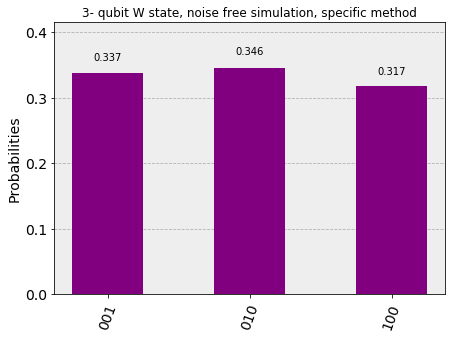

In [4]:
# Test circuit "my_state" : Noise free model on simulator
backend_sim = Aer.get_backend('qasm_simulator')
shots = 1024
job_noisefree = execute(test, backend_sim, shots=shots, max_credits=5)
job_monitor(job_noisefree)

noisefree_count = job_noisefree.result().get_counts(test)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print("Date (DMY):", time_exp)
print(noisefree_count)
plot_histogram(noisefree_count, color=['purple'], 
               title=str(n) + '- qubit W state, noise free simulation, ' +  method + " method")

In [5]:
# QASM from test
QASM_source = test.qasm()
print(QASM_source)

OPENQASM 2.0;
include "qelib1.inc";
qreg q0[3];
creg c0[3];
x q0[2];
ry(-0.955316618124509) q0[1];
cz q0[2],q0[1];
ry(0.955316618124509) q0[1];
ry(-0.785398163397448) q0[0];
cz q0[1],q0[0];
ry(0.785398163397448) q0[0];
cx q0[1],q0[2];
cx q0[0],q0[1];
measure q0[0] -> c0[0];
measure q0[1] -> c0[1];
measure q0[2] -> c0[2];



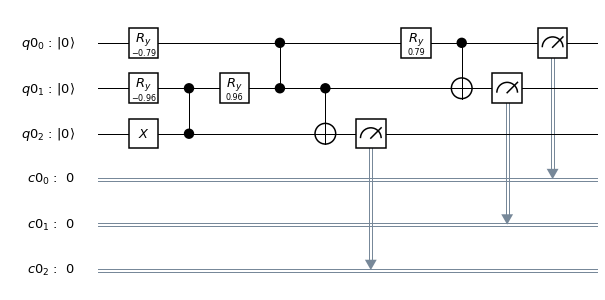

In [6]:
# Draw the circuit 
test.draw(output='mpl')

### State tomography and quantum fidelity in noise free device simulation

In [8]:
# Execute state tomography using noise free quantum device simulation

# obtain the final state vector
backend_stvct = Aer.get_backend('statevector_simulator')
job = execute(my_state, backend_stvct)
my_state_psi = job.result().get_statevector(my_state)

# construct state tomography set for measurement of qubits [0, ..., n-1] in the Pauli basis
qubit_set = []
for i in range(0,n) :
    qubit_set.append(i)

my_state_tomo_set = tomo.state_tomography_set(qubit_set) # default value for meas_basis ='Pauli'.

# add the state tomography measurement circuits to the Quantum Program
my_state_tomo_circuits = tomo.create_tomography_circuits(my_state, qr, cr, my_state_tomo_set)

backend_tomo = Aer.get_backend('qasm_simulator') # for simulation

# take 1024 shots for each measurement basis
# note: reduce this number for larger number of qubits
shots = 1024
mode = "noise free simulation"
my_state_job = execute(my_state_tomo_circuits, backend_tomo, shots=shots)
job_monitor(my_state_job)
my_state_tomo_result = my_state_job.result()    
        
# extract tomography data from results
my_state_tomo_data = tomo.tomography_data(my_state_tomo_result, my_state.name, my_state_tomo_set)

# Quantum fidelity

# reconstruct experimentally measured density matrix 
rho_fit = tomo.fit_tomography_data(my_state_tomo_data)

# calculate fidelity of fitted state:
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print("Date (DMY):", time_exp)
print('Tomography',str(n)+'-qubit W state on', backend_tomo,
      ", shots:", shots, ", method:", method, ", mode:", mode)
F_fit = state_fidelity(rho_fit, my_state_psi)
print('Fidelity with theoretical ideal state')
print('F =', F_fit)

HTML(value="<p style='font-size:16px;'>Job Status: job is actively running </p>")

Date (DMY): 07/01/2019 07:51:45
Tomography 3-qubit W state on qasm_simulator , shots: 1024 , method: specific , mode: noise free simulation
Fidelity with theoretical ideal state
F = 0.9858785193549825


### From here, you need credentials:

In [7]:
IBMQ.load_accounts()

In [13]:
backend_overview() # you may skip running this cell if you want

ibmq_16_melbourne           ibmqx4
-----------------           ------
Num. Qubits:  14            Num. Qubits:  5
Pending Jobs: 9             Pending Jobs: 92
Least busy:   True          Least busy:   False
Operational:  True          Operational:  True
Avg. T1:      55.0          Avg. T1:      49.0
Avg. T2:      74.1          Avg. T2:      25.4





In [14]:
backend_real = least_busy(IBMQ.backends(operational=True, simulator=False))
print(backend_real)

ibmq_16_melbourne


### Prepare noise simulation corresponding to a given quantum device

In [10]:
# Prepare device noise simulation (DNS)

device = backend_real
print("device: ", device)
properties = device.properties()
coupling_map = device.configuration().coupling_map
prepared = False
if device.name() == 'ibmq_16_melbourne' :
    gate_times = [
        ('u1', None, 0), ('u2', None, 100), ('u3', None, 200),
        ('cx', [1, 0], 678), ('cx', [1, 2], 547), ('cx', [2, 3], 721),
        ('cx', [4, 3], 733), ('cx', [4, 10], 721), ('cx', [5, 4], 800),
        ('cx', [5, 6], 800), ('cx', [5, 9], 895), ('cx', [6, 8], 895),
        ('cx', [7, 8], 640), ('cx', [9, 8], 895), ('cx', [9, 10], 800),
        ('cx', [11, 10], 721), ('cx', [11, 3], 634), ('cx', [12, 2], 773),
        ('cx', [13, 1], 2286), ('cx', [13, 12], 1504), ('cx', [], 800)
    ]
    prepared = True
    
elif device.name() == 'ibmqx4' :
    gate_times = [
        ('u1', None, 0), ('u2', None, 60), ('u3', None, 120),
        ('cx', [1, 0], 340), ('cx', [2, 0], 424), ('cx', [2, 1], 520),
        ('cx', [3, 2], 620), ('cx', [3, 4], 420), ('cx', [4, 2], 920)    
    ]
    prepared = True

else :
    print("No gate times yet defined in this notebook for: ", device)
        
if prepared :
    # Construct the noise model from backend properties and custom gate times
    noise_model = noise.device.basic_device_noise_model(properties, gate_times=gate_times)

    # Get the basis gates for the noise model
    basis_gates = noise_model.basis_gates
    
    print("noise model prepared for", device)


device:  ibmq_16_melbourne
noise model prepared for ibmq_16_melbourne


### Run the algorithm using device noise simulation (DNS)

HTML(value="<p style='font-size:16px;'>Job Status: job is actively running </p>")

<bound method AerJob.status of <qiskit.providers.aer.aerjob.AerJob object at 0x0000025F1FB74B00>>
Date (DMY): 08/01/2019 08:37:23
{'011': 33, '110': 26, '100': 268, '001': 303, '010': 310, '000': 39, '111': 17, '101': 28}


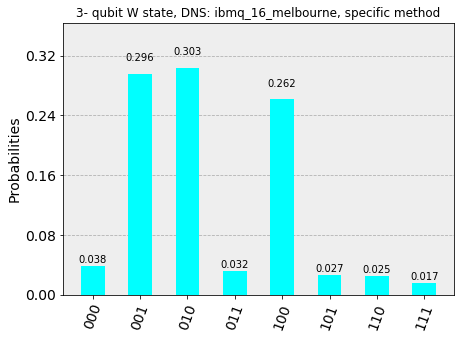

In [11]:
# Execute test using device noise simulation (DNS)

backend_noise = Aer.get_backend('qasm_simulator') # for simulation (DNS)

shots = 1024
mode = "DNS"
job_noise = execute(test, backend_noise, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates)
job_monitor(job_noise)

print(job_noise.status)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print("Date (DMY):", time_exp)
noisy_count = job_noise.result().get_counts(test) 
print(noisy_count)
plot_histogram(noisy_count, color=['cyan'],
               title= str(n) + '- qubit W state, ' + mode + ': {}, '.format(device.name()) + method + " method")

### State tomography and quantum fidelity in device noise simulation (DNS)

In [44]:
# Execute state tomography using device noise simulation (DNS)

# obtain the final state vector
backend_stvct = Aer.get_backend('statevector_simulator')
job = execute(my_state, backend_stvct)
my_state_psi = job.result().get_statevector(my_state)

# construct state tomography set for measurement of qubits [0, ..., n-1] in the Pauli basis
qubit_set = []
for i in range(0,n) :
    qubit_set.append(i)
my_state_tomo_set = tomo.state_tomography_set(qubit_set) # default value for meas_basis ='Pauli'.    

# add the state tomography measurement circuits to the Quantum Program
my_state_tomo_circuits = tomo.create_tomography_circuits(my_state, qr, cr, my_state_tomo_set)

backend_tomo = Aer.get_backend('qasm_simulator') # for simulation

# take 1024 shots for each measurement basis
# note: reduce this number for larger number of qubits
shots = 1024
mode = "DNS"
my_state_job = execute(my_state_tomo_circuits, backend_tomo, 
                               noise_model=noise_model,
                               coupling_map=coupling_map,
                               basis_gates=basis_gates)
job_monitor(my_state_job)
my_state_tomo_result = my_state_job.result()    

# extract tomography data from results
my_state_tomo_data = tomo.tomography_data(my_state_tomo_result, my_state.name, my_state_tomo_set)

# Quantum fidelity

# reconstruct experimentally measured density matrix 
rho_fit = tomo.fit_tomography_data(my_state_tomo_data)

# calculate fidelity of fitted state:
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print("Date (DMY):", time_exp)
print('Tomography',str(n)+'-qubit W state on', backend_tomo,
      ", shots:", shots, ", method:", method, ", mode:", mode, "of", device)
F_fit = state_fidelity(rho_fit, my_state_psi)
print('Fidelity with theoretical ideal state')
print('F =', F_fit)

HTML(value="<p style='font-size:16px;'>Job Status: job is actively running </p>")

Date (DMY): 07/01/2019 15:17:10
Tomography 3-qubit W state on qasm_simulator , shots: 1024 , method: specific , mode: DNS of ibmq_16_melbourne
Fidelity with theoretical ideal state
F = 0.796346002046457


### Results using device noise simulation (DNS)###

The following results were obtained by device noise simulation on the qasm simulator, with the ibmqx4 as model, using 1024 shots for each tomographic circuit. 

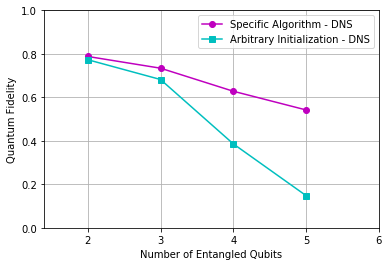

In [42]:
plt.xlabel('Number of Entangled Qubits')
plt.ylabel('Quantum Fidelity')
plt.axis([1.4, 6, 0, 1])
plt.grid()
plt.plot([2,3,4,5], [0.788,0.734,0.628,0.542], 'mo-', label="Specific Algorithm - DNS")
plt.plot([2,3,4,5], [0.773,0.682,0.386,0.148], 'cs-', label="Arbitrary Initialization - DNS")
plt.legend()
plt.show()

### Run the algorithm on superconducting quantum computing device (SQC)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

<bound method IBMQJob.status of <qiskit.providers.ibmq.ibmqjob.IBMQJob object at 0x0000025F1FD42128>>
{'011': 35, '110': 39, '100': 200, '001': 318, '010': 264, '000': 124, '111': 21, '101': 23}


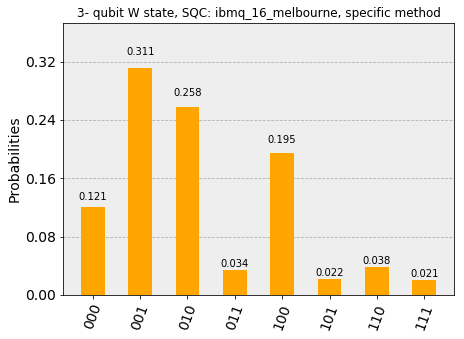

In [12]:
# Execute test using superconducting quantum computing device (SQC)

#Choose the backend
#backend_noise = Aer.get_backend('qasm_simulator') # for optional test before final experiment 
backend_noise = device # for least busy SQC device

# Execute on SQC and get counts
shots = 1024
if backend_noise.name() == "qasm_simulator" : # optional test before final experiment 
    mode = "DNS"
    job_noise = execute(test, backend_noise, 
                           noise_model=noise_model,
                           coupling_map=coupling_map,
                           basis_gates=basis_gates)
else: # final experiment on real device
    mode = "SQC"
    job_noise = execute(test, backend_noise)
    job_monitor(job_noise)

print(job_noise.status)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
noisy_count = job_noise.result().get_counts(test) 
print(noisy_count)
plot_histogram(noisy_count, color=['orange'], 
               title= str(n) + '- qubit W state, ' + mode + ': {}, '.format(device.name()) + method + " method")

### State tomography and quantum fidelity on superconducting quantum computing device (SQC)

In [15]:
# Execute state tomography on superconducting quantum computing device (SQC)

# obtain the final state vector
backend_stvct = Aer.get_backend('statevector_simulator')
job = execute(my_state, backend_stvct)
my_state_psi = job.result().get_statevector(my_state)

# construct state tomography set for measurement of qubits [0, ..., n-1] in the Pauli basis
qubit_set = []
for i in range(0,n) :
    qubit_set.append(i)

my_state_tomo_set = tomo.state_tomography_set(qubit_set) # default value for meas_basis ='Pauli'.

# add the state tomography measurement circuits to the Quantum Program
my_state_tomo_circuits = tomo.create_tomography_circuits(my_state, qr, cr, my_state_tomo_set)

#Choose the backend
#backend_tomo = Aer.get_backend('qasm_simulator') # optional test before final experiment
backend_tomo = device # for least busy SQC device

# take 1024 shots for each measurement basis
# note: reduce this number for larger number of qubits
shots = 1024

# loop: 27 circuits maximum per job to avoid exceeding the allowed limit for the real device.  
n_circ = 3**n
i_max = min(27,n_circ)
my_jobs = []
index_job = -1
for i in range(0,n_circ,i_max) :
    circs =[]
    for j in range(i, i+i_max):
        circs.append(my_state_tomo_circuits[j])
    if backend_tomo.name() == "qasm_simulator" : # optional test before final experiment
        mode = "DNS"
        my_state_job = execute(circs, backend_tomo, 
                               noise_model=noise_model,
                               coupling_map=coupling_map,
                               basis_gates=basis_gates)
    else: # final experiment on real device
        mode = "SQC" 
        my_state_job = execute(circs, backend_tomo, shots=shots)
    my_jobs.append(my_state_job)
    index_job = index_job + 1 
    job_monitor(my_jobs[index_job], monitor_async = True)
    
    my_state_new_result = my_state_job.result()
    if i == 0:
        my_state_tomo_result = my_state_new_result
    else:
        my_state_tomo_result = my_state_tomo_result +  my_state_new_result

# extract tomography data from results
my_state_tomo_data = tomo.tomography_data(my_state_tomo_result, my_state.name, my_state_tomo_set)

# Quantum fidelity

# reconstruct experimentally measured density matrix 
rho_fit = tomo.fit_tomography_data(my_state_tomo_data)

# calculate fidelity of fitted state:
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print("Date (DMY):", time_exp)
print('Tomography',str(n)+'-qubit W state on', backend_tomo,
      ", shots:", shots, ", method:", method, ", mode:", mode, device)
F_fit = state_fidelity(rho_fit, my_state_psi)
print('Fidelity with theoretical ideal state')
print('F =', F_fit)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Date (DMY): 08/01/2019 10:58:17
Tomography 3-qubit W state on ibmq_16_melbourne , shots: 1024 , method: specific , mode: SQC ibmq_16_melbourne
Fidelity with theoretical ideal state
F = 0.6806596009461401


### Results for superconducting quantum computing device (SQC)###

The following results were obtained on the ibmqx4 superconductive quantum computing system using 1024 shots for each tomographic circuit:

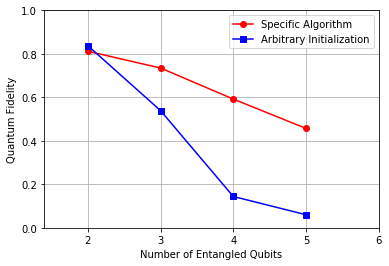

In [11]:
plt.xlabel('Number of Entangled Qubits')
plt.ylabel('Quantum Fidelity')
plt.axis([1.4, 6, 0, 1])
plt.grid()
plt.plot([2,3,4,5], [0.812,0.735,0.592,0.457], 'ro-', label="Specific Algorithm")
plt.plot([2,3,4,5], [0.838,0.539,0.144,0.060], 'bs-', label="Arbitrary Initialization")
plt.legend()
plt.show()

### Comparing DNS to SQC
The results mentioned above for the DNS and SQC experiments are illustrated together in the next graphs:

Herafter a comparison of the histograms of estimated outcome probabilities obtained during noise-free simulation, DNS and SQC experiments of deterministic generation of W states by the specific algorithm on ibmqx4 using Qiskit 0.7 (Note that the results were less convincing using the ibmq_16_melbourne as shown above).

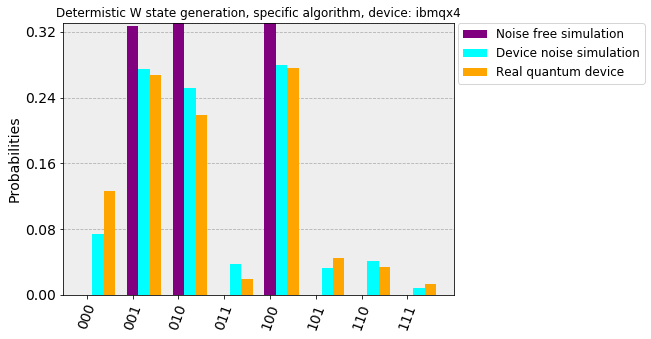

In [39]:
# DSN vs SQC, count histograms
# Shots = 1024
count_noisefree = {'010': 344, '001': 335, '100': 345}
count_DNS = {'110': 42, '010': 258, '111': 9, '011': 38, '000': 76, '001': 281, '100': 286, '101': 34}
count_real = {'001': 274, '000': 129, '010': 224, '011': 20, '100': 282, '111': 14, '101': 46, '110': 35} 
plot_histogram([count_noisefree, count_DNS, count_real], 
               title= 'Determistic W state generation, specific algorithm, device: ibmqx4', 
               color=['purple','cyan', 'orange'], bar_labels=False,
               legend = ['Noise free simulation', 'Device noise simulation','Real quantum device']) 

Hereafter a comparison of the quantum fidelity estimated by state tomography for device noise simulation (DSN) and real device (SQC), using either the specific algorithm or arbitrary  initialization:

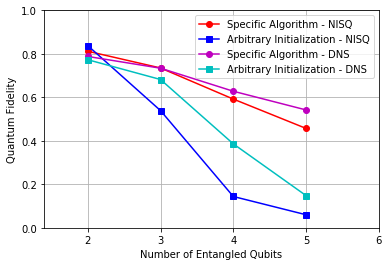

In [12]:
plt.xlabel('Number of Entangled Qubits')
plt.ylabel('Quantum Fidelity')
plt.axis([1.4, 6, 0, 1])
plt.grid()
plt.plot([2,3,4,5], [0.812,0.735,0.592,0.457], 'ro-', label="Specific Algorithm - SQC")
plt.plot([2,3,4,5], [0.838,0.539,0.144,0.060], 'bs-', label="Arbitrary Initialization - SQC")
plt.plot([2,3,4,5], [0.788,0.734,0.628,0.542], 'mo-', label="Specific Algorithm - DNS")
plt.plot([2,3,4,5], [0.773,0.682,0.386,0.148], 'cs-', label="Arbitrary Initialization - DNS")
plt.legend()
plt.show()

### Concluding remarks:

The efficiency of the more compact specific algorithm as a deterministic $ |W_{n}\rangle$ production tool, when estimated from the quantum fidelity, is clearly related to the linear progression of the number of required gates when n increases. On the other hand, the arbitrary initialization requires a number of gate increasing geometrically.
This can be appreciated by looking at the qasm source and the circuit drawings of the respective circuits.

The comparison between DNS and SQC shows a good fit of the simulator noise model with the real results of the ibmqx4 device.

Beyond the comparison of two algorithms for deterministic production of multi-qubit W states, the approach presented here can be generalized to the study of a variety of other quantum states, for example GHZ.
 
This type of approach can also be considered for the validation of device noise simulation models.

### References:

[1] Dür, W., Vidal, G., & Cirac, J. I. (2000). Three qubits can be entangled in two inequivalent ways. Physical Review A, 62(6), 062314. 

[2] Diker, F. (2016). Deterministic construction of arbitrary W states with quadratically increasing number of two-qubit gates. arXiv preprint arXiv:1606.09290. https://arxiv.org/abs/1606.09290v2

[3] Smolin, J. A., Gambetta, J. M. & Smith, G. (2012). Efficient method for computing the maximum-likelihood quantum state from measurements with additive gaussian noise. Phys. Rev. Lett 108(7). https://link.aps.org/doi/10.1103/PhysRevLett.108.070502